# AutoML for Images

### Painting images classification with Azure ML and AutoML for Images (Image Classification Task)

We will build a computer vision model to detect paintings from some famous painters from any object.

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/capturepainting.jpg?raw=true" width=200>

Full images are available here: https://www.kaggle.com/ikarus777/best-artworks-of-all-time

## Setup
> To use this notebook, **you will need to install the private preview package for AutoML for Images from the private index**.

In [1]:
#!pip install --upgrade "azureml-train-core<0.1.1" "azureml-train-automl<0.1.1" "azureml-contrib-dataset<0.1.1" --extra-index-url "https://azuremlsdktestpypi.azureedge.net/automl_for_images_private_preview/"

In [2]:
#!pip install seaborn

## 1. Informations

In [3]:
import numpy as np
import json
import os
import urllib
from zipfile import ZipFile
import seaborn as sns
import pandas as pd

In [4]:
import sys
print("Python version =", sys.version)

Python version = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [5]:
import datetime
now = datetime.datetime.now()
print("Today =", now)

Today = 2021-05-27 12:50:41.267195


In [6]:
import azureml.core
print("You are using Azure ML version", azureml.core.VERSION)

You are using Azure ML version 0.1.0.36994775


In [7]:
# Your local platform
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platform']=platform.system()
        info['Platform-release']=platform.release()
        info['Platform-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processor']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1046-azure',
 'Platform-version': '#48~18.04.1-Ubuntu SMP Tue Apr 13 19:41:38 UTC 2021',
 'Architecture': 'x86_64',
 'Hostname': 'standardd15v2',
 'IP-address': '127.0.0.1',
 'MAC-address': '1f:dc:ca:d1:6b:3f',
 'Processor': 'x86_64',
 'RAM': '138 Go'}

## 2. Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

> Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [8]:
subscription_id='Tobereplaced'   
resource_group='automlvision-rg'   
workspace_name='automlvision'

In [9]:
from azureml.core import Workspace
try:
   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
   ws.write_config()
   print("OK")
except:
   print("Error: Workspace not found")

OK


In [10]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [11]:
ws.name, ws.resource_group

('automlvision', 'automlvision-rg')

## 3. Azure ML GPU Compute target setup
**You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training.** <br><br>
**AutoML models for image tasks require GPU SKUs and support NC and ND families.** We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [12]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpu-painting"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', #GPU cluster
                                                           idle_seconds_before_scaledown=1800, #Time out
                                                           min_nodes=0, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Creating a new compute target...
Creating.........
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [13]:
# Compute status
compute_target.provisioning_state

'Succeeded'

In [14]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 0,
 'targetNodeCount': 0,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2021-05-27T12:51:20.077000+00:00',
 'errors': None,
 'creationTime': '2021-05-27T12:50:47.383552+00:00',
 'modifiedTime': '2021-05-27T12:51:32.909623+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC6'}

In [15]:
# Compute VM size
compute_target.vm_size

'STANDARD_NC6'

## 4. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [16]:
from azureml.core import Experiment

experiment_name = 'AutomlImages-Paintings' #Name of your experimentation
experiment = Experiment(ws, name=experiment_name)

In [17]:
experiment

Experiment(Name: AutomlImages-Paintings,
Workspace: automlvision)

## 5. Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

### List of images files

In [18]:
%cd imagespaintings

/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd15v2/code/Users/seretkow/AutoML Painters/imagespaintings


In [19]:
# We have some images for the 2 tags in 2 directories we want to detect : mask / NoMask
print(os.listdir('.'))

['.ipynb_checkpoints', 'Alfred Sisley', 'El Grego', 'Klint', 'Modigliani', 'Monet', 'Picasso', 'Rembrandt', 'train_annotations.jsonl', 'validation_annotations.jsonl', 'Van Gogh']


In [20]:
for root, _, files in os.walk('.'):
    print("Dir:", root, "with", len(files), "images files.")

Dir: . with 2 images files.
Dir: ./.ipynb_checkpoints with 0 images files.
Dir: ./Alfred Sisley with 100 images files.
Dir: ./El Grego with 87 images files.
Dir: ./Klint with 117 images files.
Dir: ./Modigliani with 132 images files.
Dir: ./Monet with 73 images files.
Dir: ./Picasso with 103 images files.
Dir: ./Rembrandt with 138 images files.
Dir: ./Van Gogh with 180 images files.


### Some samples:

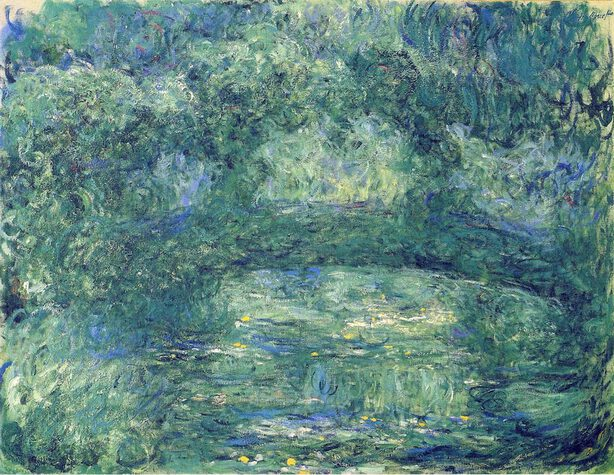

In [21]:
from IPython.display import Image
sample_image = 'Monet/Claude_Monet_1.jpg'
Image(filename=sample_image) 

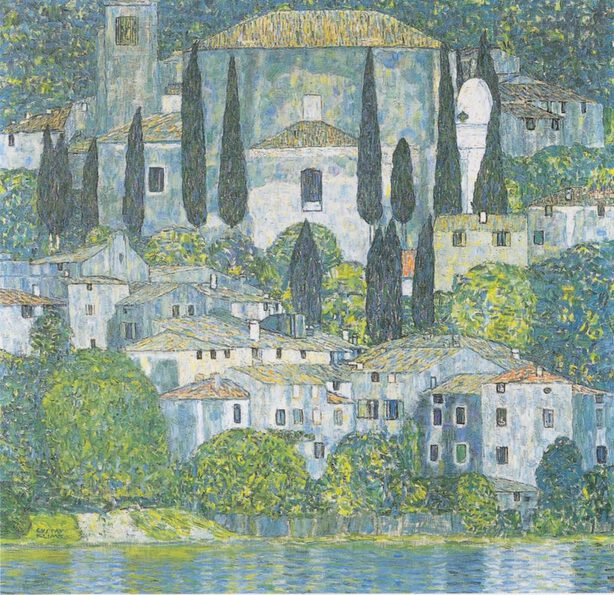

In [22]:
from IPython.display import Image
sample_image = 'Klint/Gustav_Klimt_2.jpg'
Image(filename=sample_image) 

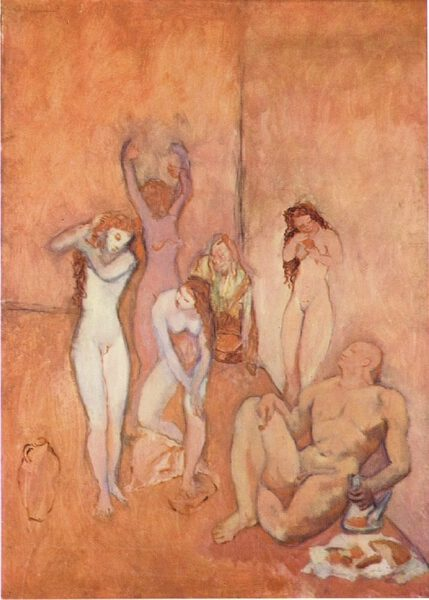

In [28]:
from IPython.display import Image
sample_image = 'Picasso/Pablo_Picasso_20.jpg'
Image(filename=sample_image) 

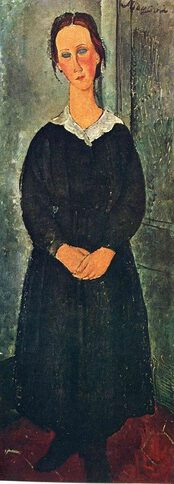

In [29]:
from IPython.display import Image
sample_image = 'Modigliani/Amedeo_Modigliani_1.jpg'
Image(filename=sample_image) 

### Convert the downloaded data to JSONL


In [30]:
%cd ..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd15v2/code/Users/seretkow/AutoML Painters


In [31]:
src = "imagespaintings/"

train_validation_ratio = 5

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = \
    {
        "image_url": "AmlDatastore://" + workspaceblobstore + "/"
                     + os.path.basename(os.path.dirname(src)),
        "label": "",
        "label_confidence": 1.0
    }

index = 0
# Scan each sub directary and generate jsonl line
with open(train_annotations_file, 'w') as train_f:
    with open(validation_annotations_file, 'w') as validation_f:
        for className in os.listdir(src):
            subDir = src + className
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing imagespaintings/.ipynb_checkpoints
Parsing imagespaintings/Alfred Sisley
Parsing imagespaintings/El Grego
Parsing imagespaintings/Klint
Parsing imagespaintings/Modigliani
Parsing imagespaintings/Monet
Parsing imagespaintings/Picasso
Parsing imagespaintings/Rembrandt
Parsing imagespaintings/Van Gogh


### Upload the JSONL file and images to Datastore  
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. It is an abstraction over Azure Storage.



In [32]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir='./imagespaintings/', target_path='imagespaintings')

Uploading an estimated of 932 files
Target already exists. Skipping upload for imagespaintings/train_annotations.jsonl
Target already exists. Skipping upload for imagespaintings/validation_annotations.jsonl
Target already exists. Skipping upload for imagespaintings/Alfred Sisley/Alfred_Sisley_1.jpg
Target already exists. Skipping upload for imagespaintings/Alfred Sisley/Alfred_Sisley_10.jpg
Target already exists. Skipping upload for imagespaintings/Alfred Sisley/Alfred_Sisley_100.jpg
Target already exists. Skipping upload for imagespaintings/Alfred Sisley/Alfred_Sisley_11.jpg
Target already exists. Skipping upload for imagespaintings/Alfred Sisley/Alfred_Sisley_12.jpg
Target already exists. Skipping upload for imagespaintings/Alfred Sisley/Alfred_Sisley_13.jpg
Target already exists. Skipping upload for imagespaintings/Alfred Sisley/Alfred_Sisley_14.jpg
Target already exists. Skipping upload for imagespaintings/Alfred Sisley/Alfred_Sisley_15.jpg
Target already exists. Skipping upload fo

$AZUREML_DATAREFERENCE_92a83a0118f14c3584685d19e1d9be97

Finally, we need to create an Azure ML [Dataset](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [33]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset

training_dataset_name = 'PaintingsTrainingDataset'
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)
else:
    # create training dataset
    training_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('imagespaintings/train_annotations.jsonl'))
    training_dataset = training_dataset.register(workspace=ws, name=training_dataset_name)
    
# create validation dataset
validation_dataset_name = "PaintingsValidationDataset"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print('Found the validation dataset', validation_dataset_name)
else:
    validation_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('imagespaintings/validation_annotations.jsonl'))
    validation_dataset = validation_dataset.register(workspace=ws, name=validation_dataset_name)

print()
print("Training dataset name:" + training_dataset.name)
print("Validation dataset name:" + validation_dataset.name)

Found the training dataset PaintingsTrainingDataset
Found the validation dataset PaintingsValidationDataset

Training dataset name:PaintingsTrainingDataset
Validation dataset name:PaintingsValidationDataset


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the documentation for more details.

This is what the training dataset looks like

In [34]:
df=training_dataset.to_pandas_dataframe()

In [35]:
df.head()

image_url          label  \
0  StreamInfo(AmlDatastore://imagespaintings/Alfr...  Alfred Sisley   
1  StreamInfo(AmlDatastore://imagespaintings/Alfr...  Alfred Sisley   
2  StreamInfo(AmlDatastore://imagespaintings/Alfr...  Alfred Sisley   
3  StreamInfo(AmlDatastore://imagespaintings/Alfr...  Alfred Sisley   
4  StreamInfo(AmlDatastore://imagespaintings/Alfr...  Alfred Sisley   

   label_confidence  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4               1.0

In [36]:
df.shape

(744, 3)

In [37]:
# Counts images by labels
df['label'].value_counts()

Van Gogh         144
Rembrandt        111
Modigliani       105
Klint             94
Picasso           82
Alfred Sisley     80
El Grego          69
Monet             59
Name: label, dtype: int64

In [38]:
# Percentage values
df['label'].value_counts(normalize=True)

Van Gogh         0.193548
Rembrandt        0.149194
Modigliani       0.141129
Klint            0.126344
Picasso          0.110215
Alfred Sisley    0.107527
El Grego         0.092742
Monet            0.079301
Name: label, dtype: float64

## 6. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the 'AutoMLImageConfig' - please refer to the [documentation](https://github.com/swatig007/automlForImages#readme) for the details on the parameters that can be used and their values. 

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones.<br><br> **Currently supported model algorithms for image classification: 'resnet18', 'resnet34', 'resnet50', 'mobilenetv2', 'seresnext'.**

### Using default hyperparameter values for the specified algorithm

Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say **resnet50**), you can specify the config for your AutoML Image runs as follows:

In [39]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import RandomParameterSampling
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice

In [40]:
# AutoML Configuration
image_config_resnet50 = AutoMLImageConfig(task='image-classification', # AutoML Vision task
                                          compute_target=compute_target, # Compute target
                                          training_data=training_dataset, # Training dataset
                                          validation_data=validation_dataset, # Validation dataset
                                          hyperparameter_sampling=GridParameterSampling({'model_name': 
                                                                                        choice('resnet50')})) # CV Model

## 7. Submitting an AutoML run for Computer Vision tasks 
Once you've created the config settings for your run, **you can submit an AutoML run** using the config in order to train a vision model using your training dataset.

In [41]:
automl_image_run = experiment.submit(image_config_resnet50)

Submitting remote run.


In [42]:
automl_image_run.wait_for_completion(wait_post_processing=True) # Wait until automl run is finished

{'runId': 'AutoML_64d9bf17-3781-4617-941e-abfb132a5038',
 'target': 'gpu-painting',
 'status': 'Completed',
 'startTimeUtc': '2021-05-27T12:53:21.000668Z',
 'endTimeUtc': '2021-05-27T13:07:32.86251Z',
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-painting',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlImages-Paintings","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"automlvision-rg","workspace_name":"automlvision","region":"westeurope","compute_target":"gpu-painting","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":"accuracy","task_type":"imag

In [43]:
automl_image_run.id

'AutoML_64d9bf17-3781-4617-941e-abfb132a5038'

In [44]:
experiment

Experiment(Name: AutomlImages-Paintings,
Workspace: automlvision)

In [45]:
# List of all the AutoML for Images metrics values
automlvisionmetrics = automl_image_run.get_metrics()
metricsdf=pd.DataFrame(automl_image_run.get_metrics())
metricsdf

average_class_f2_score  average_sample_f2_score  average_class_f1_score  \
0                   34.995                   46.237                  33.045   
1                   65.498                   69.355                  64.266   
2                   64.430                   69.355                  65.385   
3                   69.414                   72.581                  69.919   
4                   71.366                   75.269                  71.235   
5                   71.978                   74.731                  72.747   
6                   75.015                   75.806                  75.176   
7                   75.750                   78.495                  75.945   
8                   82.637                   83.333                  82.523   
9                   84.265                   86.022                  84.237   
10                  85.171                   87.097                  85.202   
11                  82.142                   83.333                  81.997   
12                  82.253                   83.871                  82.199   
13                  83.173                   84.946                  83.158   
14                  83.205                   84.946                  83.219   

    average_sample_f1_score  recall  precision     iou  accuracy  \
0                    46.237  38.543     49.223  46.237    46.237   
1                    69.355  66.964     65.401  69.355    69.355   
2                    69.355  64.627     71.267  69.355    69.355   
3                    72.581  69.694     75.345  72.581    72.581   
4                    75.269  72.150     74.538  75.269    75.269   
5                    74.731  72.502     78.570  74.731    74.731   
6                    75.806  75.230     76.977  75.806    75.806   
7                    78.495  76.086     79.114  78.495    78.495   
8                    83.333  82.807     82.686  83.333    83.333   
9                    86.022  84.397     84.601  86.022    86.022   
10                   87.097  85.252     85.675  87.097    87.097   
11                   83.333  82.451     82.503  83.333    83.333   
12                   83.871  82.366     82.380  83.871    83.871   
13                   84.946  83.275     83.480  84.946    84.946   
14                   84.946  83.275     83.539  84.946    84.946   

    average_class_recall  average_class_precision  
0                 38.543                   49.223  
1                 66.964                   65.401  
2                 64.627                   71.267  
3                 69.694                   75.345  
4                 72.150                   74.538  
5                 72.502                   78.570  
6                 75.230                   76.977  
7                 76.086                   79.114  
8                 82.807                   82.686  
9                 84.397                   84.601  
10                85.252                   85.675  
11                82.451                   82.503  
12                82.366                   82.380  
13                83.275                   83.480  
14                83.275                   83.539

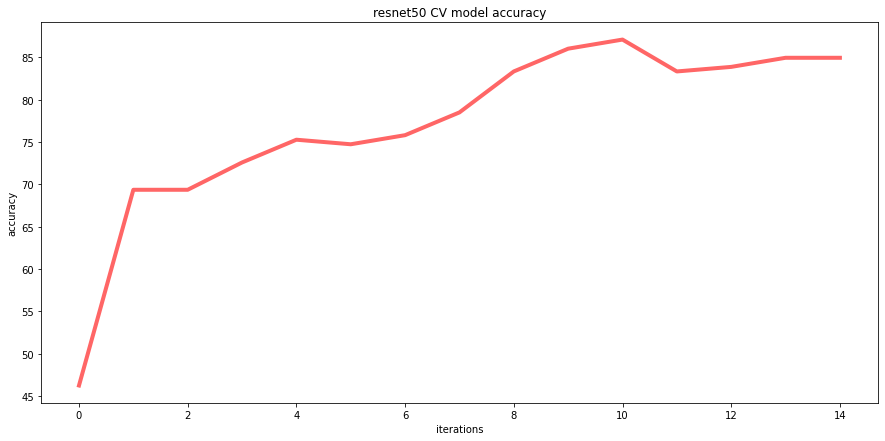

In [46]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))
plt.plot(automlvisionmetrics['accuracy'], 'r-', lw=4, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('resnet50 CV model accuracy', fontsize=12)

plt.savefig('accuracy_resnet50.jpg', dpi=150) # Saving image in a jpg file
automl_image_run.log_image(name='accuracy_resnet50.jpg', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

In [47]:
# Checking the output graph
!ls accuracy_resnet50.jpg -l

-rwxrwxrwx 1 root root 95115 May 27 13:07 accuracy_resnet50.jpg


In [48]:
# You can view the jpg file in the experiment
experiment

Experiment(Name: AutomlImages-Paintings,
Workspace: automlvision)

## 8. Register the optimal CV model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [49]:
from azureml.core import Run
hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + '_HD')
hyperdrive_run

Run(Experiment: AutomlImages-Paintings,
Id: AutoML_64d9bf17-3781-4617-941e-abfb132a5038_HD,
Type: hyperdrive,
Status: Completed)

In [50]:
# Defining tags for the custom vision model
cvmodel_tags={"Data": "Images", 
              "Context" : "Painter Detection",
              "Task" : "Best AutoML Images",
              "Framework" : "AzureML AutoML for Images",
              "AutoML Metric" : "Accuracy"}

In [51]:
# Register the best model from the AutoML Vision run
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

model = best_child_run.register_model(model_name = model_name,
                                      model_path='outputs/model.pt',
                                      description='Painter Detection Classification CV model',
                                      tags=cvmodel_tags)

In [52]:
# We can download the CV model
model.download(target_dir='.', exist_ok=True)

'model.pt'

In [53]:
# Checking the downloaded .pt model file
!ls model.pt -l

-rwxrwxrwx 1 root root 188565912 May 27 13:07 model.pt


### Model informations from the Azure ML model repository

In [54]:
model

Model(workspace=Workspace.create(name='automlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='automlvision-rg'), name=AutoML64d9bf1730, id=AutoML64d9bf1730:1, version=1, tags={'Data': 'Images', 'Context': 'Painter Detection', 'Task': 'Best AutoML Images', 'Framework': 'AzureML AutoML for Images', 'AutoML Metric': 'Accuracy'}, properties={})

In [55]:
model.id

'AutoML64d9bf1730:1'

In [56]:
model.name

'AutoML64d9bf1730'

In [57]:
model.version

1

In [58]:
model.tags

{'Data': 'Images',
 'Context': 'Painter Detection',
 'Task': 'Best AutoML Images',
 'Framework': 'AzureML AutoML for Images',
 'AutoML Metric': 'Accuracy'}

In [59]:
model.created_time

datetime.datetime(2021, 5, 27, 13, 7, 45, 220910, tzinfo=<isodate.tzinfo.Utc object at 0x7f7754427978>)

## 9. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. **You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)).**<br><br> ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage. <br><br>
**In this tutorial, we will deploy the model as a web service in AKS.**
You will need to first create an AKS compute cluster, or use an existing AKS cluster. <br>
You can use either GPU or CPU VM SKUs for your deployment cluster

In [60]:
%%time
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "cluster-aks-gpu"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6", 
                                                        location="eastus2")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                      name=aks_name, 
                                      provisioning_configuration=prov_config)
    aks_target.wait_for_completion(show_output=True)

Creating a new compute target...
Creating.................................................................................
SucceededProvisioning operation finished, operation "Succeeded"
CPU times: user 956 ms, sys: 192 ms, total: 1.15 s
Wall time: 6min 53s


Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.  
You can then deploy the model as an AKS web service.

In [61]:
# Settings

from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py', output_file_path='score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='score.py', environment=environment)

endpoint_name='automlpaintermodel' #Name of the deployed model

aks_tags={"Data": "Images", 
          "Topic" : "Painter Detection Custom Vision model", 
          "Task" : "Image Classification",
          "Framework" : "AutoML Images best model", 
          "AKS" : "True"}

aks_description="Computer vision model to identify the painter"

aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,                                                    
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True,
                                                description=aks_description,
                                                tags=aks_tags)

In [62]:
# Checking the file we downloaded
!ls score.py -l

-rwxrwxrwx 1 root root 1921 May 27 13:14 score.py


In [63]:
# Viewing the score.py file
with open(os.path.join('score.py'), 'r') as f:
    print(f.read())

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------
import os
import tempfile
import logging

from azureml.contrib.services.aml_request import rawhttp
from azureml.automl.core.shared import logging_utilities
from azureml.contrib.services.aml_response import AMLResponse

from azureml.contrib.automl.dnn.vision.common.utils import _set_logging_parameters
from azureml.contrib.automl.dnn.vision.common.model_export_utils import load_model, run_inference
from azureml.contrib.automl.dnn.vision.common.logging_utils import get_logger

from azureml.contrib.automl.dnn.vision.classification.inference.score import _score_with_model

TASK_TYPE = 'image-classification'
logger = get_logger('azureml.automl.core.scoring_script_images')


def init():
    global model
    
    # Set up logging
    _set_logging_parameters(TASK_TYPE, {})

    model_path = os.path.join(os.getenv('AZU

### Let's deploy the CV model into AKS

In [64]:
%%time
aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name=endpoint_name,
                           overwrite=True)

aks_service.wait_for_deployment(show_output=True)

print("\nDone. Model is deployed. Ready to use!")
print("\nAKS service status=", aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-27 13:14:53+00:00 Creating Container Registry if not exists.
2021-05-27 13:14:53+00:00 Registering the environment.
2021-05-27 13:14:54+00:00 Use the existing image..
2021-05-27 13:14:57+00:00 Creating resources in AKS..
2021-05-27 13:15:02+00:00 Submitting deployment to compute.
2021-05-27 13:15:02+00:00 Checking the status of deployment automlpaintermodel..
2021-05-27 13:22:06+00:00 Checking the status of inference endpoint automlpaintermodel.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done. Model is deployed. Ready to use!

AKS service status= Healthy
CPU times: user 1.17 s, sys: 183 ms, total: 1.35 s
Wall time: 7min 32s


> Usually it takes 2 or 3 minutes to deploy. You can see the endpoint in Azure ML Studio

In [65]:
print("Computer Vision model endpoint:", aks_service.scoring_uri)

Computer Vision model endpoint: http://20.80.224.236:80/api/v1/service/automlpaintermodel/score


In [66]:
print("Computer Vision model endpoint properties:", aks_service.properties)

Computer Vision model endpoint properties: {'hasInferenceSchema': 'False', 'hasHttps': 'False'}


In [67]:
print("Computer Vision model endpoint tags:", aks_service.tags)

Computer Vision model endpoint tags: {'Data': 'Images', 'Topic': 'Painter Detection Custom Vision model', 'Task': 'Image Classification', 'Framework': 'AutoML Images best model', 'AKS': 'True'}


In [68]:
# You can have access to the logs
#print(aks_service.get_logs())

## 10. Test our deployed CV model
Finally, let's test our deployed Computer Vision model to predict new images. You can pass in any image.

In [69]:
print("Our Computer Vision model endpoint:", aks_service.scoring_uri)
print("\nStatus=", aks_service.state)

Our Computer Vision model endpoint: http://20.80.224.236:80/api/v1/service/automlpaintermodel/score

Status= Healthy


### Test 1

Let's download an image file to test:

In [70]:
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/testvangoghtshirt.jpg?raw=true'
image_file = 'test1.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Image is downloaded and ready to be predicted.")

Image is downloaded and ready to be predicted.


In [71]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: test1.jpg
- Image shape: (800, 800, 3)
- Image size: 1920000


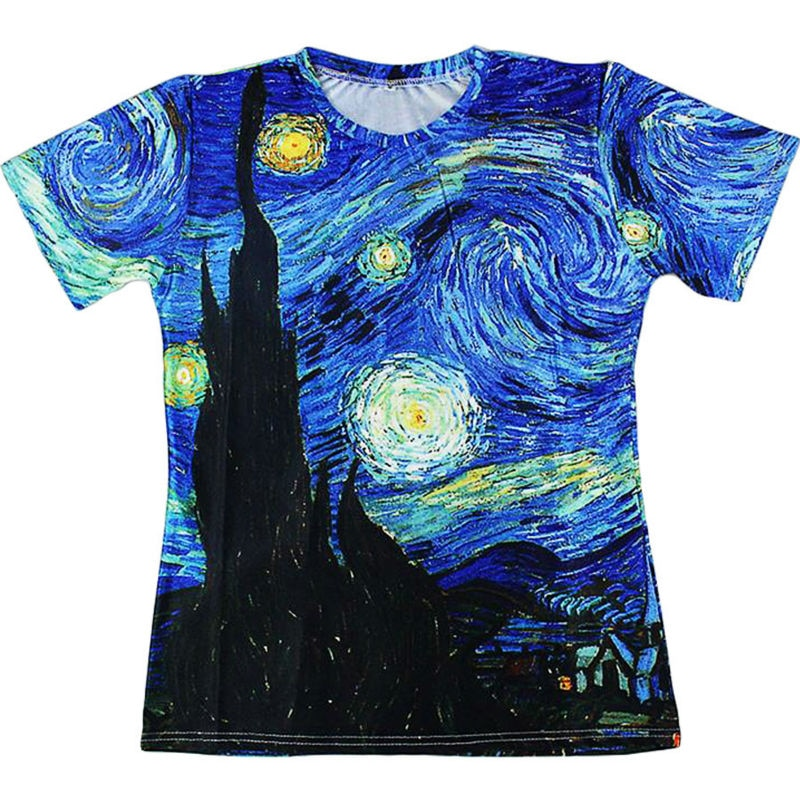

In [72]:
from IPython.display import Image
Image(filename=image_file)

In [73]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Status code= 200

Elapsed= 0:00:00.518003

Results= {"filename": "/tmp/tmp7dhgkr_o", "probs": [0.0004712491063401103, 0.0002392882015556097, 0.031104905530810356, 0.00011252172407694161, 0.01995982602238655, 0.013125918805599213, 0.001170842326246202, 0.9338153600692749], "labels": ["Alfred Sisley", "El Grego", "Klint", "Modigliani", "Monet", "Picasso", "Rembrandt", "Van Gogh"]}



In [82]:
prediction=pd.DataFrame(resp.json()) #Convert the Json into a pandas dataframe
prediction.sort_values(by='probs', ascending=False)

filename     probs         labels
7  /tmp/tmp7dhgkr_o  0.933815       Van Gogh
2  /tmp/tmp7dhgkr_o  0.031105          Klint
4  /tmp/tmp7dhgkr_o  0.019960          Monet
5  /tmp/tmp7dhgkr_o  0.013126        Picasso
6  /tmp/tmp7dhgkr_o  0.001171      Rembrandt
0  /tmp/tmp7dhgkr_o  0.000471  Alfred Sisley
1  /tmp/tmp7dhgkr_o  0.000239       El Grego
3  /tmp/tmp7dhgkr_o  0.000113     Modigliani

In [83]:
prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs']) # to take the max probability
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

print("Image file =", image_file)
print("Model prediction =", label, "\nwith Probability =", conf_score)
print()
print("\033[1;31;34mThis image shows or contains a", label,"art with a probability of", round((conf_score*100), 2), "%")

Image file = test1.jpg
Model prediction = Van Gogh 
with Probability = 0.9338153600692749

This image shows or contains a Van Gogh art with a probability of 93.38 %


## Visualize predictions
Now that we have scored a test image, we can visualize the prediction for this image

Van Gogh (0.93)


<Figure size 1296x864 with 0 Axes>

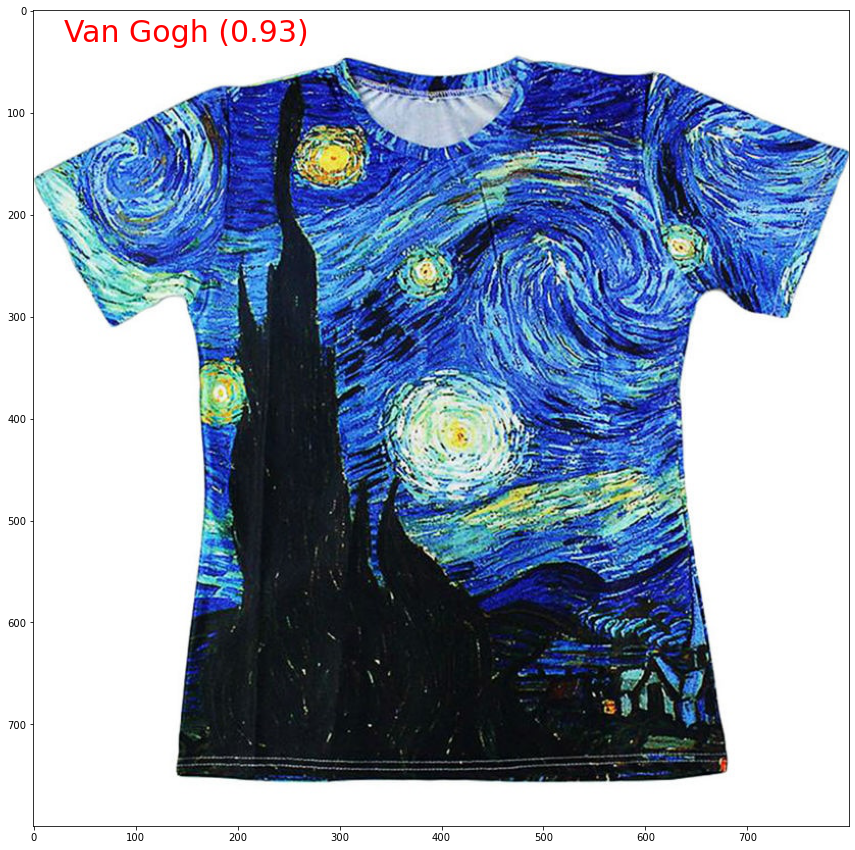

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs'])
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

display_text = '{} ({})'.format(label, round(conf_score, 2))
print(display_text)

color = 'red' # Text color
plt.text(30, 30, display_text, color=color, fontsize=30)

fig.savefig('predictiontest1.jpg', dpi=150) #Saving image

plt.show()

### Test 2

In [85]:
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/testpicasso.jpg?raw=true'
image_file = 'test2.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Image is downloaded and ready to be predicted.")

Image is downloaded and ready to be predicted.


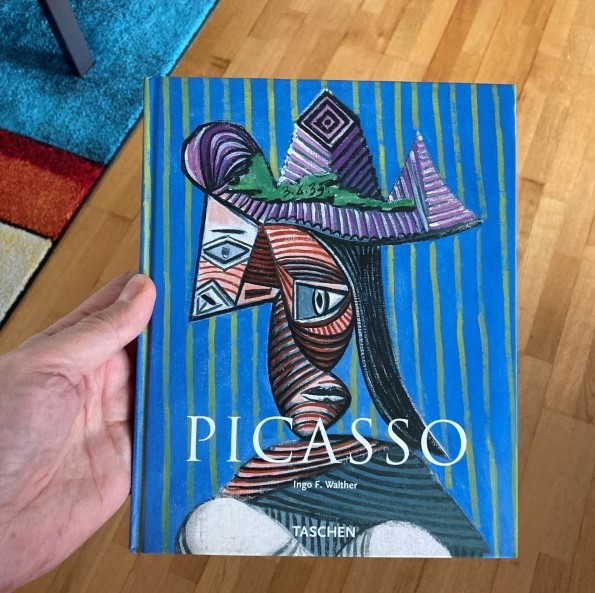

In [86]:
from IPython.display import Image
Image(filename=image_file)

In [87]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: test2.jpg
- Image shape: (593, 595, 3)
- Image size: 1058505


In [88]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

# Load image data
data = open(image_file, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/octet-stream'}

# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Status code= 200

Elapsed= 0:00:00.499843

Results= {"filename": "/tmp/tmp49xk36gi", "probs": [9.282169912694371e-07, 2.02477463062678e-06, 0.0003929207450710237, 7.157743311836384e-06, 3.4389722713967785e-05, 0.9915737509727478, 2.165507737572625e-07, 0.007988521829247475], "labels": ["Alfred Sisley", "El Grego", "Klint", "Modigliani", "Monet", "Picasso", "Rembrandt", "Van Gogh"]}



In [89]:
prediction=pd.DataFrame(resp.json()) #Convert the Json into a pandas dataframe
prediction.sort_values(by='probs', ascending=False)

filename         probs         labels
5  /tmp/tmp49xk36gi  9.915738e-01        Picasso
7  /tmp/tmp49xk36gi  7.988522e-03       Van Gogh
2  /tmp/tmp49xk36gi  3.929207e-04          Klint
4  /tmp/tmp49xk36gi  3.438972e-05          Monet
3  /tmp/tmp49xk36gi  7.157743e-06     Modigliani
1  /tmp/tmp49xk36gi  2.024775e-06       El Grego
0  /tmp/tmp49xk36gi  9.282170e-07  Alfred Sisley
6  /tmp/tmp49xk36gi  2.165508e-07      Rembrandt

In [90]:
prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs']) # to take the max probability
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

print("Image file =", image_file)
print("Model prediction =", label, "\nwith Probability =", conf_score)
print()
print("\033[1;31;34mThis image shows or contains a", label,"art with a probability of", round((conf_score*100), 2), "%")

Image file = test2.jpg
Model prediction = Picasso 
with Probability = 0.9915737509727478

This image shows or contains a Picasso art with a probability of 99.16 %


This painting is a Picasso (0.99)


<Figure size 1296x864 with 0 Axes>

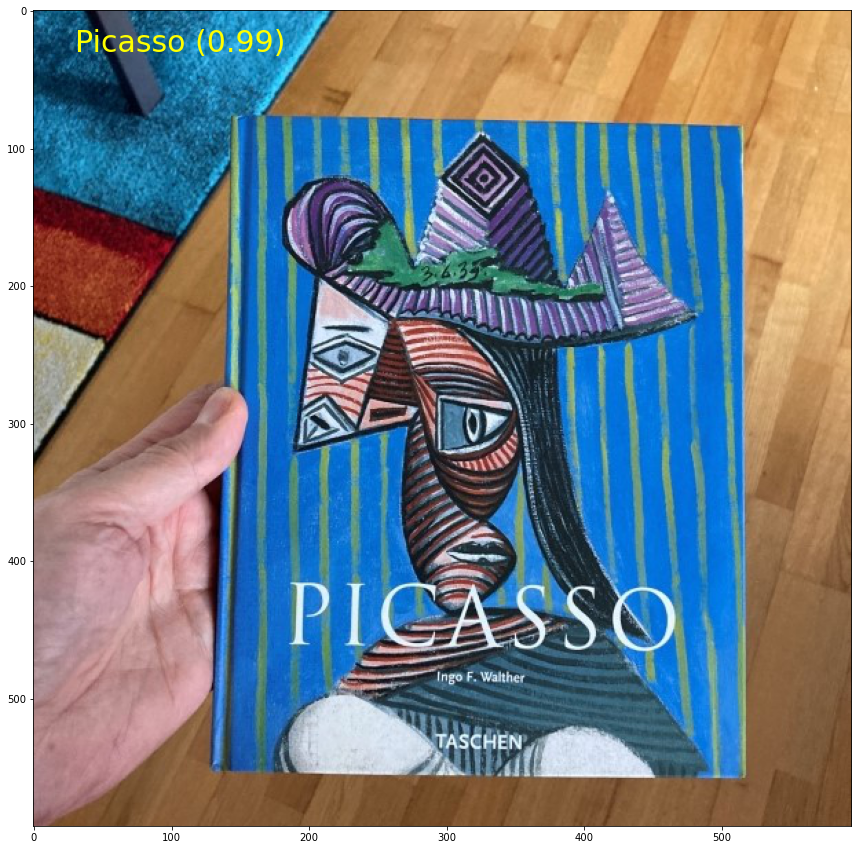

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs'])
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

display_text = '{} ({})'.format(label, round(conf_score, 2))
print("This painting is a", display_text)

color = 'yellow' #Text Color
plt.text(30, 30, display_text, color=color, fontsize=30)

fig.savefig('predictiontest2.jpg', dpi=150) #Saving image

plt.show()

### Test 3

In [102]:
image_url = 'https://th.bing.com/th/id/OIP.wf5DHPYyJt6uMbTBTJy7cQHaL3?pid=ImgDet&rs=1'
image_file = 'test3.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Image is downloaded and ready to be predicted.")

Image is downloaded and ready to be predicted.


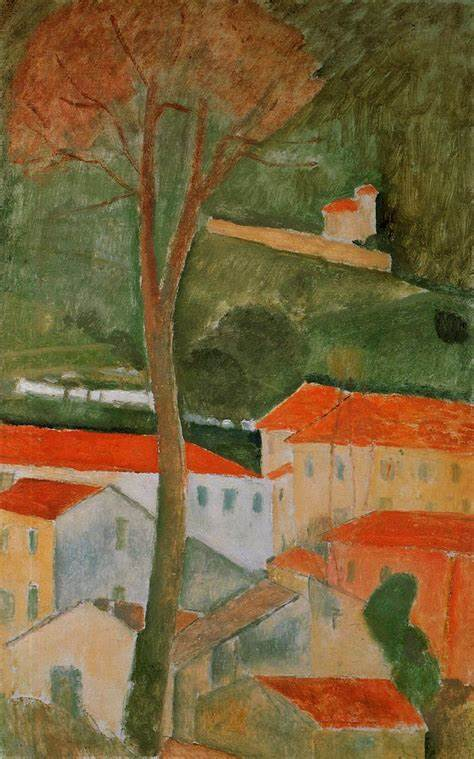

In [103]:
from IPython.display import Image
Image(filename=image_file)

In [104]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: test3.jpg
- Image shape: (759, 474, 3)
- Image size: 1079298


In [105]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

# Load image data
data = open(image_file, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/octet-stream'}

# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Status code= 200

Elapsed= 0:00:00.410362

Results= {"filename": "/tmp/tmp6wngyq_4", "probs": [0.0004865860100835562, 0.003609533654525876, 0.0854644924402237, 0.8178395628929138, 0.013018576428294182, 0.055951524525880814, 0.0015319990925490856, 0.022097745910286903], "labels": ["Alfred Sisley", "El Grego", "Klint", "Modigliani", "Monet", "Picasso", "Rembrandt", "Van Gogh"]}



In [107]:
prediction=pd.DataFrame(resp.json()) #Convert the Json into a pandas dataframe
prediction.sort_values(by='probs', ascending=False)

filename     probs         labels
3  /tmp/tmp6wngyq_4  0.817840     Modigliani
2  /tmp/tmp6wngyq_4  0.085464          Klint
5  /tmp/tmp6wngyq_4  0.055952        Picasso
7  /tmp/tmp6wngyq_4  0.022098       Van Gogh
4  /tmp/tmp6wngyq_4  0.013019          Monet
1  /tmp/tmp6wngyq_4  0.003610       El Grego
6  /tmp/tmp6wngyq_4  0.001532      Rembrandt
0  /tmp/tmp6wngyq_4  0.000487  Alfred Sisley

In [108]:
prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs']) # to take the max probability
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

print("Image file =", image_file)
print("Model prediction =", label, "\nwith Probability =", conf_score)
print()
print("\033[1;31;34mThis image shows or contains a", label,"art with a probability of", round((conf_score*100), 2), "%")

Image file = test3.jpg
Model prediction = Modigliani 
with Probability = 0.8178395628929138

This image shows or contains a Modigliani art with a probability of 81.78 %


This painting is a Modigliani (0.82)


<Figure size 1296x864 with 0 Axes>

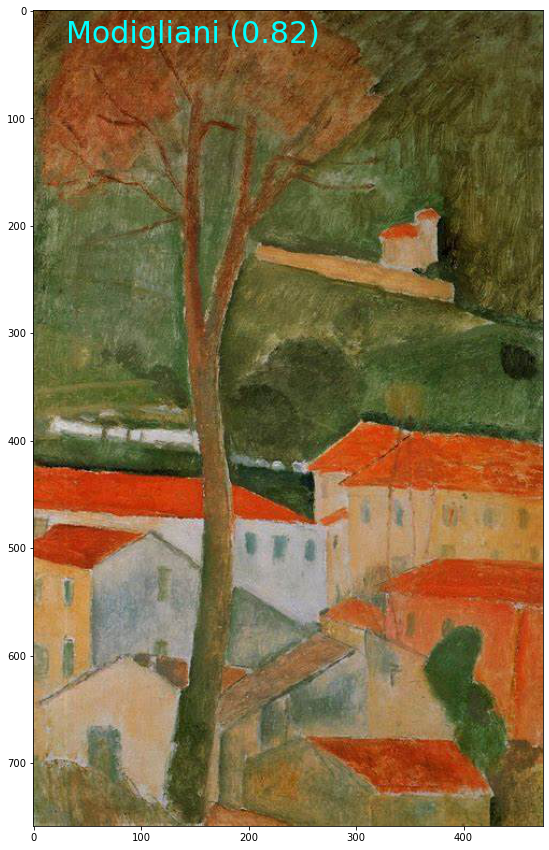

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
ax.imshow(img_np)

prediction = json.loads(resp.text)
label_index = np.argmax(prediction['probs'])
label = prediction['labels'][label_index]
conf_score = prediction['probs'][label_index]

display_text = '{} ({})'.format(label, round(conf_score, 2))
print("This painting is a", display_text)

color = 'cyan' #Text Color

plt.text(30, 30, display_text, color=color, fontsize=30)
fig.savefig('predictiontest3.jpg', dpi=150) #Saving image

plt.show()

## 11. Clean up ressources

In [111]:
# Let's delete the model
model.delete
# Let's delete the service
aks_service.delete()
# Let's delete our Azure ML GPU compute cluster
compute_target.delete()

> End of notebook